# Re Evaluate the data

In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import modules.missing as ms
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
import toad
from toad.plot import bin_plot, badrate_plot
from toad.metrics import KS, AUC
from imblearn.combine import SMOTETomek
import scorecardpy as sc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, balanced_accuracy_score, auc
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV

## Load Data

In [2]:
app_train = pd.read_csv('../data/application_train_cleaned.csv')
bb = pd.read_csv('../data/bureau_balance.csv')
bureau = pd.read_csv('../data/bureau_clean.csv')
ccb = pd.read_csv('../data/credit_card_balance_clean.csv')
installments = pd.read_csv('../data/installments_payments_clean.csv')
pos_cash = pd.read_csv('../data/pos_cash_balance_clean.csv')
previous = pd.read_csv('../data/previous_application_clean1.csv')

## Bureau data group by and joining

bb aggragate to show average MONTHS_BALANCE()

In [3]:
# aggreagate bureau balance Months' balance with mean for every unique bureau id
bb_agg = bb.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].mean().reset_index(name='AVG_MONTHS_BALANCE')

# join aggregated bureau balance with bureau
bureau_semi_join = pd.merge(bureau, bb_agg, on='SK_ID_BUREAU', how='left')

# aggregate current credit amount and current debt(on credit bureau) with sum for every unique current application id
bureau_agg = bureau_semi_join.groupby('SK_ID_CURR')[['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT']].sum().reset_index()

## Join bureau and application train

In [4]:
# left join application train with aggregated bureau 
train_bureau = pd.merge(app_train, bureau_agg, on='SK_ID_CURR', how='left')

## Payment installments aggregation and feature creation

In [5]:
# installment payment data joining and aggregating
installments_agg = installments.groupby(['SK_ID_PREV', 'SK_ID_CURR'])[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum().reset_index()

# Differences between annuity installment and the client actually paid, 
# the more the value is far away from 0 the more probability of client to be a bad client 
installments_agg['DIFF_INSTALLMENT_PAYMENT'] = installments_agg['AMT_INSTALMENT'] - installments_agg['AMT_PAYMENT']
installments_agg = installments_agg.drop(columns='SK_ID_CURR', axis=1)

## Join payment isntallments with previous application

In [6]:
# join installment with previous application
prev_installments = pd.merge(previous, installments_agg, on='SK_ID_PREV', how='left')

## Credit Card Balance Aggregate and Join

In [7]:
ccb_agg = ccb.groupby('SK_ID_PREV')[['AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT']].sum().reset_index()

prev_ccb = pd.merge(prev_installments, ccb_agg, on='SK_ID_PREV', how='left')

## Pos Cash Balance Aggregate and Join

In [8]:
pc_agg = pos_cash.groupby('SK_ID_PREV')['SK_DPD'].mean().reset_index(name='AVERAGE_DPD')

prev_pc = pd.merge(prev_ccb, pc_agg, on='SK_ID_PREV', how='left')

## Train Full

In [9]:
train_full = pd.merge(train_bureau, prev_pc, on='SK_ID_CURR', how='left', suffixes=('_curr', '_prev'))

In [10]:
# train_full.to_csv('../data/train_full.csv', index=False)

In [10]:
pd.set_option('display.max_columns', None)

display(train_full.sample(10))
print(f'Application train data contains: \n{train_full.shape[0]} rows and {train_full.shape[1]} columns')
print(f'\nApplication train data information:\n')
print(train_full.info())
print(f'\nStatistical Summary of numerical columns:\n')

numerical = train_full.select_dtypes(include='number')
display(numerical.describe())

categorical = train_full.select_dtypes(include='object')
display(categorical.describe())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_curr,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,NAME_CONTRACT_TYPE_prev,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_GOODS_PRICE_prev,WEEKDAY_APPR_PROCESS_START_prev,HOUR_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_LAST_DUE,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AVERAGE_DPD
769552,292582,0,Cash loans,M,Y,Y,0,157500.0,808650.0,26217.0,675000.0,"Spouse, partner",Working,Secondary / secondary special,Married,House / apartment,0.003813,-12163,-1384,-547.0,-4221,1,1,1,1,1,0,2.0,2,2,THURSDAY,10,0,0,0,0,1,1,Transport: type 2,0.445782,0.0,0.0,0.0,0.0,-2287.0,4.545000e+06,0.00,1008002.0,Revolving loans,5625.000,0.0,112500.0,0.0,MONDAY,6.0,Y,1.0,XAP,Approved,-2509.0,XNA,XAP,Repeater,XNA,Cards,x-sell,Country-wide,41.0,Connectivity,0.0,XNA,Card Street,-1630.0,237919.905,237919.905,0.000,2059366.77,219375.0,NaN
795924,299066,0,Revolving loans,F,N,Y,0,270000.0,450000.0,22500.0,450000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Separated,House / apartment,0.032561,-18650,-1104,-1646.0,-2180,1,1,0,1,0,1,1.0,1,1,FRIDAY,19,0,0,0,0,0,0,Business Entity Type 3,0.762118,0.0,0.0,0.0,0.0,-1727.0,1.433534e+07,1285389.00,2261568.0,Consumer loans,3546.765,40455.0,34569.0,40455.0,FRIDAY,17.0,Y,1.0,XAP,Approved,-2268.0,Cash through the bank,XAP,New,Computers,POS,XNA,Country-wide,2709.0,Consumer electronics,12.0,middle,POS household with interest,-1937.0,42405.480,42405.480,0.000,NaN,NaN,0.000000
512007,228081,0,Cash loans,F,Y,Y,1,135000.0,224149.5,24268.5,193500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.019101,-14125,-5464,-3537.0,-4304,1,1,0,1,0,0,3.0,2,2,WEDNESDAY,8,0,0,0,0,1,1,Transport: type 4,0.485535,0.0,0.0,0.0,0.0,-762.0,8.073955e+05,124386.84,2654259.0,Cash loans,0.000,0.0,0.0,0.0,WEDNESDAY,10.0,Y,1.0,XNA,Canceled,-126.0,XNA,XAP,Repeater,XNA,XNA,XNA,Credit and cash offices,-1.0,XNA,0.0,XNA,Cash,0.0,NaN,NaN,NaN,NaN,NaN,NaN
580265,245102,1,Cash loans,F,N,Y,0,81000.0,521280.0,22216.5,450000.0,Unaccompanied,Pensioner,Secondary / secondary special,Single / not married,House / apartment,0.006852,-18482,365243,-8742.0,-1880,1,0,0,1,1,0,1.0,3,3,TUESDAY,5,0,0,0,0,0,0,XNA,0.355702,0.0,0.0,0.0,0.0,-1817.0,NaN,NaN,1125493.0,Consumer loans,13773.105,137745.0,123970.5,137745.0,MONDAY,6.0,Y,1.0,XAP,Approved,-2920.0,XNA,XAP,New,Computers,POS,XNA,Stone,37.0,Consumer electronics,10.0,low_normal,POS household with interest,-2610.0,167841.135,140294.925,27546.210,NaN,NaN,2.727273
680104,270219,0,Cash loans,F,N,Y,0,180000.0,679500.0,19867.5,679500.0,Unaccompanied,Commercial associate,Lower secondary,Separated,House / apartment,0.022800,-18789,-11479,-6691.0,-2315,1,1,0,1,1,0,1.0,2,2,MONDAY,12,0,0,0,0,0,0,Industry: type 3,0.632759,1.0,0.0,1.0,0.0,-1198.0,6.234952e+06,224635.50,1191604.0,Consumer loans,8273.295,3881

Application train data contains: 
1430155 rows and 79 columns

Application train data information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430155 entries, 0 to 1430154
Data columns (total 79 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   SK_ID_CURR                       1430155 non-null  int64  
 1   TARGET                           1430155 non-null  int64  
 2   NAME_CONTRACT_TYPE_curr          1430155 non-null  object 
 3   CODE_GENDER                      1430155 non-null  object 
 4   FLAG_OWN_CAR                     1430155 non-null  object 
 5   FLAG_OWN_REALTY                  1430155 non-null  object 
 6   CNT_CHILDREN                     1430155 non-null  int64  
 7   AMT_INCOME_TOTAL                 1430155 non-null  float64
 8   AMT_CREDIT_curr                  1430155 non-null  float64
 9   AMT_ANNUITY_curr                 1430155 non-null  float64
 10  AMT_GOODS_PRIC

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_GOODS_PRICE_prev,HOUR_APPR_PROCESS_START_prev,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_LAST_DUE,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AVERAGE_DPD
count,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.254670e+06,1.254670e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,8.205850e+05,8.205850e+05,8.205850e+05,7.828500e+04,7.828500e+04,769614.000000
mean,2.784702e+05,8.624240e-02,4.038870e-01,1.736036e+05,5.893386e+05,2.704027e+04,5.289922e+05,2.079102e-02,-1.631495e+04,6.860209e+04,-5.001275e+03,-3.034492e+03,9.999993e-01,8.067175e-01,1.824732e-01,9.989917e-01,2.825792e-01,7.195793e-02,2.149003e+00,2.058179e+00,2.036176e+00,1.199401e+01,1.229377e-02,4.435953e-02,3.626041e-02,7.368082e-02,2.220151e-01,1.738609e-01,5.110974e-01,1.538150e+00,1.532512e-01,1.520324e+00,1.074548e-01,-1.076470e+03,2.048573e+06,6.631244e+05,1.922744e+06,1.239553e+04,1.752436e+05,1.963539e+05,1.752686e+05,1.247893e+01,9.964321e-01,-8.803670e+02,3.149878e+02,1.256367e+01,4.623661e+04,2.328081e+05,2.352289e+05,-2.420824e+03,2.035212e+06,2.677531e+05,1.021295
std,1.028021e+05,2.807218e-01,7.165176e-01,1.983303e+05,3.874204e+05,1.404126e+04,3.559720e+05,1.339810e-02,4.346737e+03,1.451967e+05,3.551626e+03,1.507182e+03,8.361967e-04,3.948728e-01,3.862342e-01,3.173746e-02,4.502536e-01,2.584183e-01,9.001609e-01,4.963435e-01,4.891555e-01,3.233163e+00,1.101937e-01,2.058927e-01,1.869375e-01,2.612509e-01,4.156014e-01,3.789899e-01,1.918513e-01,2.525672e+00,4.646596e-01,2.503920e+00,3.780070e-01,8.036990e+02,3.767452e+06,1.598177e+06,5.327153e+05,1.457276e+04,2.936222e+05,3.194812e+05,2.936438e+05,3.331474e+00,5.962560e-02,7.835402e+02,7.695082e+03,1.448807e+01,1.221605e+05,3.363216e+05,3.632959e+05,9.626145e+04,3.118154e+06,4.500664e+05,21.751332
min,1.000020e+05,0.000000e+00,0.000000e+00,2.565000e+04,4.500000e+04,0.000000e+00,0.000000e+00,2.900000e-04,-2.522900e+04,-1.791200e+04,-2.467200e+04,-7.197000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.292000e+03,0.000000e+00,-6.981558e+06,1.000001e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.922000e+03,-1.000000e+00,0.000000e+00,-2.889000e+03,0.000000e+00,2.070000e+00,-3.195000e+06,-1.260000e+05,0.000000e+00,0.000000
25%,1.893610e+05,0.000000e+00,0.000000e+00,1.125000e+05,2.700000e+05,1.679850e+04,2.385000e+05,1.003200e-02,-1.997500e+04,-2.825000e+03,-7.509000e+03,-4.319000e+03,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+

,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START_curr,ORGANIZATION_TYPE,NAME_CONTRACT_TYPE_prev,WEEKDAY_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701
unique,2,3,2,2,7,8,5,6,6,7,58,4,7,2,25,4,4,9,4,27,5,3,8,11,5,18
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,TUESDAY,Business Entity Type 3,Cash loans,WEDNESDAY,Y,XAP,Approved,Cash through the bank,XAP,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,1320679,964822,947544,1031672,1171310,730613,1046822,921040,1279761,251516,308918,626764,215519,1406387,786937,886099,882700,1145533,1037682,797209,592460,900053,600342,715322,429198,235101


In [12]:
xna_goods = train_full.NAME_GOODS_CATEGORY.value_counts()[0]
total_data = train_full.shape[0]
print(f'Proportion of XNA values in NAME_GOODS_CATEGORY {round((xna_goods / total_data) * 100, 2)}%')

xna_client = train_full.NAME_CLIENT_TYPE.value_counts()[0]
print(f'Proportion of XNA values in NAME_CLIENT_TYPE: {round((xna_client / total_data) * 100, 2)}%')


Proportion of XNA values in NAME_GOODS_CATEGORY 55.74%
Proportion of XNA values in NAME_CLIENT_TYPE: 72.56%


for XNA wich is not not available, the value proportion is half of the data, that we have to drop this because rest of the value around 44% is too small and considered not valid. 

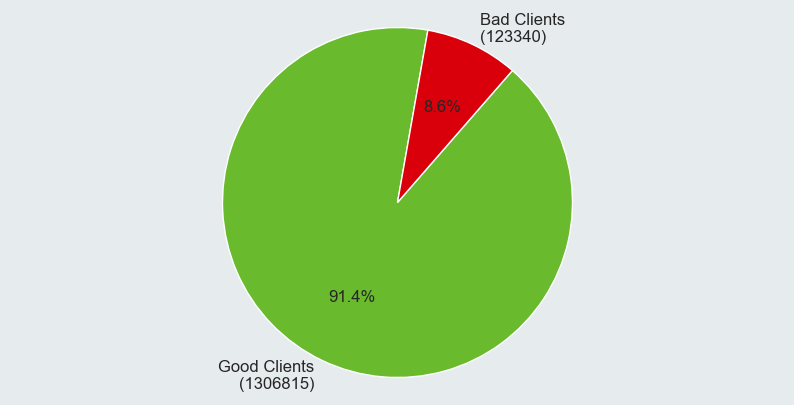

There's 1430155 Clients in our data


In [13]:
counts = train_full['TARGET'].value_counts()
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('#e6ebed')
gbp = ['#69ba2d', '#d9000c']

wedges, texts, autotexts = ax.pie(counts,
                                   labels=['Good Clients', 'Bad Clients'],
                                   autopct='%1.1f%%',
                                   colors=gbp,
                                   startangle=80)

plt.axis('equal')
for i, text in enumerate(texts):
    text.set(text=texts[i].get_text() + f'\n({counts.iloc[i]})')
    texts[i].set_fontsize(12)
plt.show()
print(f"There's {train_full.shape[0]} Clients in our data")

From the plot above, we can see that:
- From total 1430155 clients in our data.
- 1,306,815 (91.4%) clients don't have payment difficulties. 
- 123,340 (8.6%) clients have payments difficulties.
- The data is highly imbalanced.

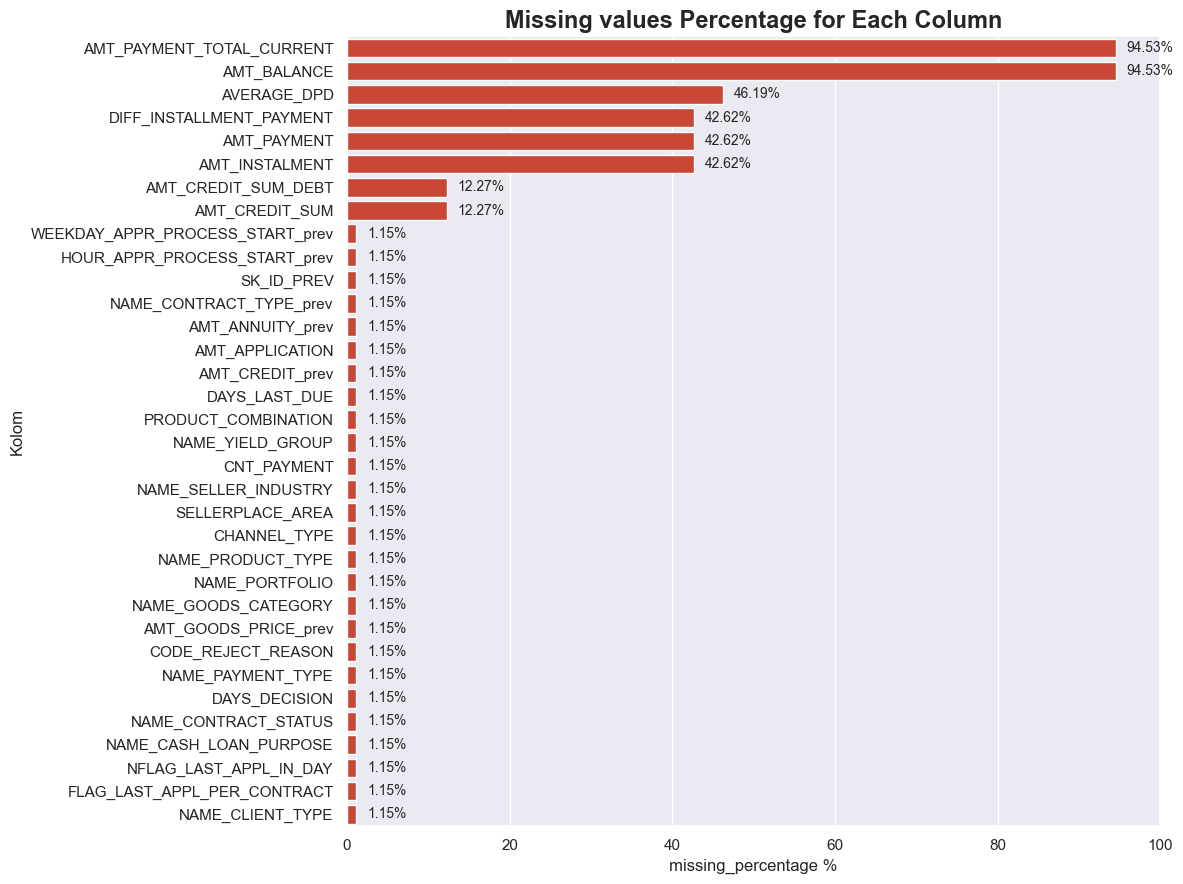

In [14]:
ms.plot_missing_percentage(train_full)

Our data Contains a lot of missing values,
- For the columns that have missing values more than 90% of the data, i will drop them.
- AVERAGE DPD missing values seems reasonable, that there's client that didn't have any DPD, or didn't have any previous application.
- for the columns `DIFF_INSTALMENT_PAYMENT`, `AMT_PAYMENT` and `AMT_INSTALMENT` i will fill the missing values with 0, because it's reasonable to assume that the client didn't have any previous application too.
- the rest of it i will leave it be, so when there's missing values, while we do woe binning, it will be treated as a separate category.

In [11]:
# x train categorical value binning
train_full['AGE'] = round(abs(train_full['DAYS_BIRTH'] / 365.25)).astype(int)

train_full = train_full[train_full.NAME_FAMILY_STATUS != 'Unknown']

# make a function to replace columns value contains XNA or XAP with np.nan
def replace_xna_xap(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].replace(['XNA', 'XAP'], np.nan)
    return df

train_full = replace_xna_xap(train_full)

# replace abnormal value
replace_val = {4.5 : 5,
               0.5 : 1}
train_full['CNT_FAM_MEMBERS'] = train_full['CNT_FAM_MEMBERS'].replace(replace_val)

train_full['REGION_RATING_CLIENT_W_CITY'] = train_full['REGION_RATING_CLIENT_W_CITY'].astype('object')
train_full['REG_CITY_NOT_WORK_CITY'] = train_full['REG_CITY_NOT_WORK_CITY'].astype('object')
train_full['REGION_RATING_CLIENT'] = train_full['REGION_RATING_CLIENT'].astype('object')

# drop unemployed, student, maternity leave, businessman
smb = ['Unemployed', 'Student', 'Maternity leave', 'Businessman']
train_full = train_full[~train_full.NAME_INCOME_TYPE.isin(smb)]
# mapping_dict = {'Family' : 'Companied',
#                 'Spouse, partner': 'Companied',
#                 'Children': 'Companied',
#                 'Other_A': 'Companied',
#                 'Other_B': 'Companied',
#                 'Group of people': 'Companied'}
# train_full = train_full.replace({'NAME_TYPE_SUITE': mapping_dict})

# map_income_val = {'Unemployed': 'Others', 
#                   'Student': 'Others', 
#                   'Materniity leave': 'Others',
#                   'Businessman': 'Others'}

# train_full = train_full.replace({'NAME_INCOME_TYPE': map_income_val})

## Oulier Cheking

In [16]:
# numvisual = train_full[[
#     'CNT_CHILDREN', 'AMT_INCOME_TOTAL','AMT_CREDIT_curr', 'AMT_ANNUITY_curr',
#     'AMT_GOODS_PRICE_curr','REGION_POPULATION_RELATIVE','DAYS_BIRTH',
#     'DAYS_EMPLOYED','DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS',
#     'REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START_curr',
#     'EXT_SOURCE_2','OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
#     'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
#     'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_ANNUITY_prev', 'AMT_APPLICATION',
#     'AMT_CREDIT_prev','AMT_GOODS_PRICE_prev', 'HOUR_APPR_PROCESS_START_prev',
#     'NFLAG_LAST_APPL_IN_DAY', 'DAYS_DECISION', 'SELLERPLACE_AREA',
#     'CNT_PAYMENT', 'DAYS_LAST_DUE', 'AMT_INSTALMENT', 'AMT_PAYMENT',
#     'DIFF_INSTALLMENT_PAYMENT', 'AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT',
#     'AVERAGE_DPD'
#           ]].copy()

# colgroup = [numvisual.columns[n:n+4] for n in range(0, len(numvisual.columns), 4)]

# # Create a 9x4 grid of subplots
# fig, axs = plt.subplots(4, 10, figsize=(30, 15))

# # for each group of 4 columns
# for i, group in enumerate(colgroup):
#     # For eachg column in the group
#     for j, column in enumerate(group):
#         # Create a boxplot for the apporopriate subplot
#         sns.boxplot(y=numvisual[column], ax=axs[j, i ], color='blue', linewidth=1.5, orient='v')
#         axs[j, i].set_title(column)

# # show plot
# plt.tight_layout()
# plt.show()

## Train Test Split

In [87]:
X = train_full.drop(columns='TARGET', axis=1)
y = train_full[['TARGET']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1103)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1072473, 79) (357492, 79) (1072473, 1) (357492, 1)


## Data filtering

In [18]:
toad.quality(X_train, target=y_train['TARGET'], iv_only=True)

,iv,gini,entropy,unique
EXT_SOURCE_2,0.286217,NaN,NaN,116293.0
DAYS_EMPLOYED,0.101107,NaN,NaN,12433.0
AMT_GOODS_PRICE_curr,0.090048,NaN,NaN,977.0
DAYS_BIRTH,0.078253,NaN,NaN,17445.0
AGE,0.077581,NaN,NaN,49.0
...,...,...,...,...
NFLAG_LAST_APPL_IN_DAY,0.000133,NaN,NaN,3.0
REG_REGION_NOT_LIVE_REGION,0.000119,NaN,NaN,2.0
FLAG_EMAIL,0.000024,NaN,NaN,2.0
FLAG_MOBIL,0.000023,NaN,NaN,2.0


In [88]:
Xtrain_selected, drop_list = toad.selection.select(frame=X_train,
                                                  target=y_train['TARGET'],
                                                  empty=0.5,
                                                  iv=0.02,
                                                  corr=0.7,
                                                  return_drop=True)

print("keep:",Xtrain_selected.shape[1],
      "drop empty:",len(drop_list['empty']),
      "drop iv:",len(drop_list['iv']),
      "drop corr:",len(drop_list['corr']))

display(Xtrain_selected)
print(f'\n{drop_list}')

keep: 25 drop empty: 7 drop iv: 42 drop corr: 5


In [ ]:
selected_features = Xtrain_selected.columns

Xtest_selected = X_test[selected_features]

In [21]:
# output the iv table to a dataframe
def iv_importance(data_selected, label):
    iv_import_feat = toad.quality(data_selected, label, iv_only=True)
    iv_import_feat = iv_import_feat['iv']
    iv_import_feat = iv_import_feat.reset_index()
    iv_import_feat.columns = ['name', 'iv']
    return iv_import_feat

df_iv = iv_importance(Xtrain_selected, y_train['TARGET'])

In [22]:
df_iv.sort_values(by='iv', ascending=False)

,name,iv
0,EXT_SOURCE_2,0.286217
1,DAYS_EMPLOYED,0.101107
2,AMT_GOODS_PRICE_curr,0.090048
3,DAYS_BIRTH,0.078253
4,ORGANIZATION_TYPE,0.069430
5,AMT_CREDIT_SUM_DEBT,0.069113
6,NAME_INCOME_TYPE,0.056952
7,DAYS_LAST_PHONE_CHANGE,0.055948
8,REGION_RATING_CLIENT_W_CITY,0.046869
9,PRODUCT_COMBINATION,0.043714


ORGANIZATION_TYPE column A variable with many unique values, also known as a high-cardinality categorical variable, can indeed pose challenges. It can lead to a large number of bins if we're doing binning, or a large number of dummy variables if we're doing one-hot encoding. This can make our model complex and slow to train. so i decided to drop this column.

In [16]:
Xtrain_selected.drop(columns='ORGANIZATION_TYPE', axis=1, inplace=True)
Xtest_selected.drop(columns='ORGANIZATION_TYPE', axis=1, inplace=True)

## Handling rest of Missing Values

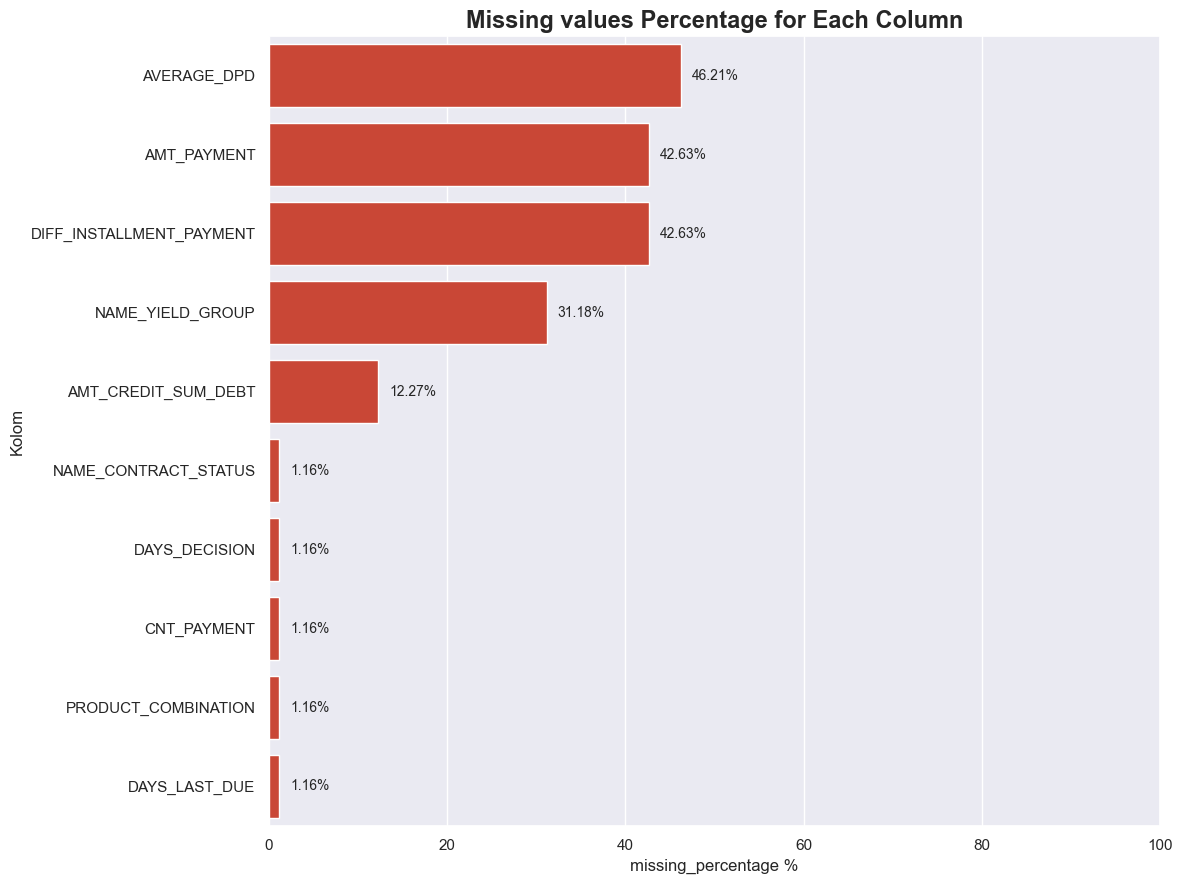

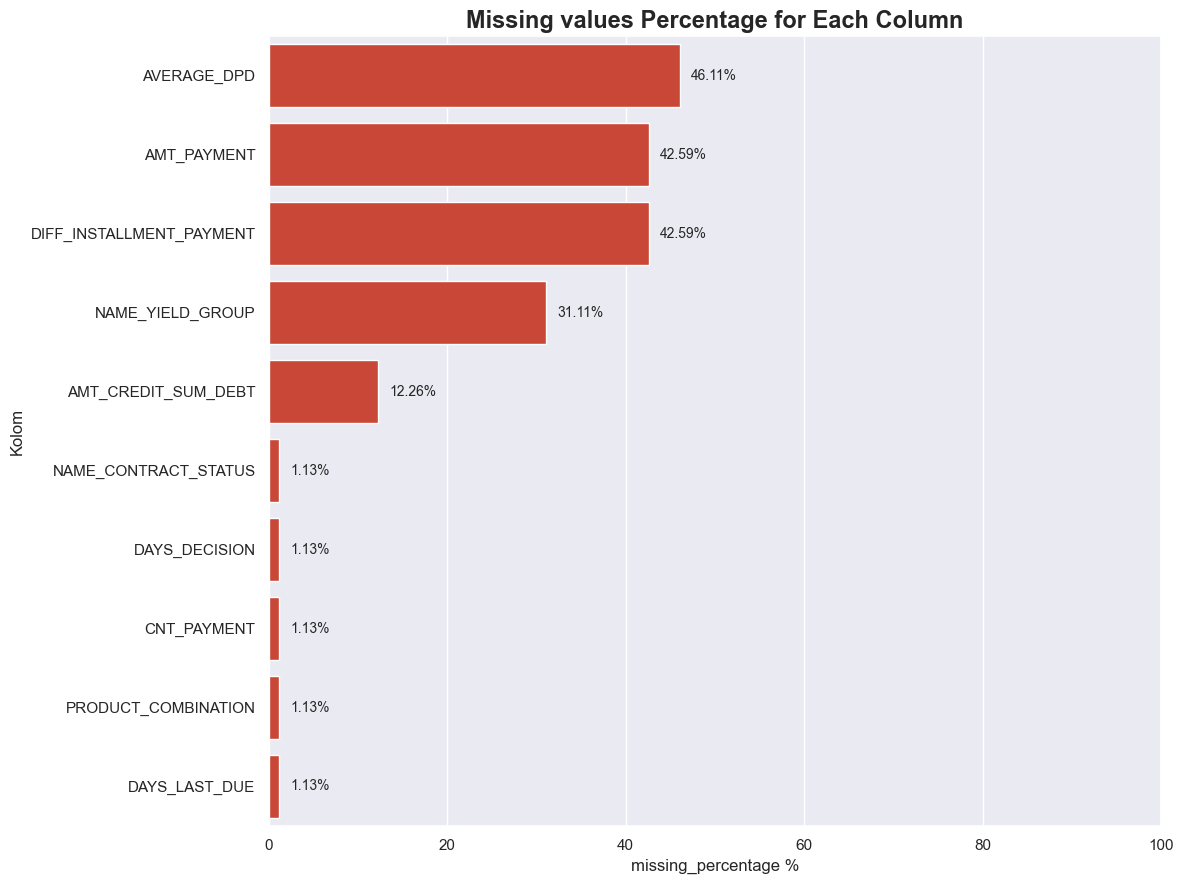

None

None

In [24]:
display(ms.plot_missing_percentage(Xtrain_selected), ms.plot_missing_percentage(Xtest_selected))


In [17]:
# X train missing values handling
fillzero = ['AVERAGE_DPD', 'DIFF_INSTALLMENT_PAYMENT', 'AMT_PAYMENT', 'AMT_CREDIT_SUM_DEBT']
Xtrain_selected[fillzero] = Xtrain_selected[fillzero].fillna(0)


train_missing = Xtrain_selected[Xtrain_selected.columns[Xtrain_selected.isna().any()]] 
traincol = train_missing.columns

for col in traincol:
    if Xtrain_selected[col].dtype == 'object':
        Xtrain_selected[col].fillna(Xtrain_selected[col].mode()[0], inplace=True)
    else:
        Xtrain_selected[col].fillna(Xtrain_selected[col].median(), inplace=True)


# # X test missing values handling
Xtest_selected[fillzero] = Xtest_selected[fillzero].fillna(0)


test_missing = Xtest_selected[Xtest_selected.columns[Xtest_selected.isna().any()]]
testcol = test_missing.columns

for col in testcol:
    if Xtest_selected[col].dtype == 'object':
        Xtest_selected[col].fillna(Xtest_selected[col].mode()[0], inplace=True)
    else:
        Xtest_selected[col].fillna(Xtest_selected[col].median(), inplace=True)

## Handling Outlier

In [31]:
def cap_outliers(data, columns):
    # Create a copy of the data to avoid modifying the original DataFrame
    result = data.copy()

    # Loop over each column in the provided list
    for col in columns:
        # Calculate the first quartile (Q1) for the current column
        Q1 = result[col].quantile(0.25)
        # Calculate the third quartile (Q3) for the current column
        Q3 = result[col].quantile(0.75)
        # Calculate the Interquartile Range (IQR) for the current column
        IQR = Q3 - Q1
        # Calculate the lower bound for the current column
        lower_bound = Q1 - (1.5 * IQR)
        # Calculate the upper bound for the current column
        upper_bound = Q3 + (1.5 * IQR)
        # Replace values in the current column that are less than the lower bound with the lower bound
        result[col] = np.where(result[col] < lower_bound, lower_bound, result[col])
        # Replace values in the current column that are greater than the upper bound with the upper bound
        result[col] = np.where(result[col] > upper_bound, upper_bound, result[col])
    # Return the DataFrame with capped outliers
    return result


# Select the names of all numerical columns in the DataFrame X_train_c2
outliers = ['AMT_GOODS_PRICE_curr', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 
            'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE',
            'AMT_CREDIT_SUM_DEBT', 'DAYS_DECISION', 'CNT_PAYMENT', 'DAYS_LAST_DUE']

# Call the cap_outliers function on X_train_c2, passing in the names of the numerical columns
# This will cap the outliers in these columns, and the result is stored in X_train_c3
Xtrain_noutlier = cap_outliers(Xtrain_selected, outliers)

## Feature Encoding

In [19]:
def dummy_creation(data, cols_list):
    data_dummies = []
    for col in cols_list:
        data_dummies.append(pd.get_dummies(data[col], prefix=col, prefix_sep=':').astype(int))
    data_dummies = pd.concat(data_dummies, axis=1)
    data = pd.concat([data, data_dummies], axis=1)
    return data

In [36]:
# Xtrain_noutlier.drop(columns='PRODUCT_COMBINATION', axis=1, inplace=True)
# Xtest_selected.drop(columns='PRODUCT_COMBINATION', axis=1, inplace=True)

In [37]:
Xtrain_noutlier['REGION_RATING_CLIENT_W_CITY'] = Xtrain_noutlier['REGION_RATING_CLIENT_W_CITY'].astype('object')
Xtrain_noutlier['REG_CITY_NOT_WORK_CITY'] = Xtrain_noutlier['REG_CITY_NOT_WORK_CITY'].astype('object')

cat_colt = Xtrain_noutlier.select_dtypes(include='object').columns
cat_colts = Xtrain_noutlier.select_dtypes(include='object').columns

Xtrain_encoded = dummy_creation(Xtrain_noutlier, cat_colt)
Xtrain_encoded = Xtrain_encoded.drop(columns=cat_colt, axis=1)

Xtest_encoded = dummy_creation(Xtest_selected, cat_colts)
Xtest_encoded = Xtest_encoded.drop(columns=cat_colts, axis=1)

## Feature Binning

In [83]:
Xtrain_bin = Xtrain_encoded.copy()

# function to bin the numerical columns
def bin_feats(data, features, bins=10):
    for col in features:
        data[col] = pd.cut(data[col], bins=bins)
    return data

features_to_bin = ['AMT_GOODS_PRICE_curr', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 
                   'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE', 
                   'AMT_CREDIT_SUM_DEBT', 'DAYS_DECISION', 'CNT_PAYMENT', 'DAYS_LAST_DUE', 'AMT_PAYMENT', 
                   'DIFF_INSTALLMENT_PAYMENT', 'AVERAGE_DPD']

Xtrain_bin = bin_feats(Xtrain_bin, features_to_bin, bins=10)

Xtest_bin = Xtest_encoded.copy()
Xtest_bin = bin_feats(Xtest_bin, features_to_bin, bins=10)

## WoE Transformation

In [22]:
# function to woe variable
def woe_continous(data, continous_col, y_data):
    data = pd.concat([data[continous_col], y_data], axis=1)
    data = pd.concat([data.groupby(data.columns.values[0], as_index=False)[data.columns.values[1]].count(),
                      data.groupby(data.columns.values[0], as_index=False)[data.columns.values[1]].mean()], axis=1)
    data = data.iloc[:, [0, 1, 3]]
    data.columns = [data.columns.values[0], 'n_obs', 'prop_good']
    data['prop_n_obs'] = data['n_obs'] / data['n_obs'].sum()
    data['n_good'] = data['prop_good'] * data['n_obs']
    data['n_bad'] = (1 - data['prop_good']) * data['n_obs']
    data['prop_n_good'] = data['n_good'] / data['n_good'].sum()
    data['prop_n_bad'] = data['n_bad'] / data['n_bad'].sum()
    data['WoE'] = np.log(data['prop_n_good'] / data['prop_n_bad'])
    data = data.sort_values(['WoE'])
    data = data.reset_index(drop=True)
    data['diff_prop_good'] = data['prop_good'].diff().abs()
    data['diff_WoE'] = data['WoE'].diff().abs()
    data['IV'] = (data['prop_n_good'] - data['prop_n_bad']) * data['WoE']
    data['IV'] = data['IV'].sum()
    return data

In [23]:
def apply_woe_to_df(df, y_data):
    woe_df = pd.DataFrame()
    for col in df.columns:
        woe_data = woe_continous(df, col, y_data)
        woe_dict = dict(zip(woe_data[col], woe_data['WoE']))
        woe_df[col] = df[col].map(woe_dict)
    return woe_df

In [84]:
# Apply the function to data train
Xtrain_woe = apply_woe_to_df(Xtrain_bin, y_train)

# Apply the function to data test
Xtest_woe = apply_woe_to_df(Xtest_bin, y_test)

In [85]:
Xtrain_woe['AMT_PAYMENT'].value_counts()

AMT_PAYMENT
 0.001780    1067813
-0.497058       4402
-0.487342        219
-0.897626         27
-inf              12
Name: count, dtype: int64

In [44]:
Xtrain_woe.sample(30)

,AMT_GOODS_PRICE_curr,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM_DEBT,DAYS_DECISION,CNT_PAYMENT,DAYS_LAST_DUE,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AVERAGE_DPD,CODE_GENDER:F,CODE_GENDER:M,NAME_INCOME_TYPE:Commercial associate,NAME_INCOME_TYPE:Pensioner,NAME_INCOME_TYPE:State servant,NAME_INCOME_TYPE:Working,NAME_EDUCATION_TYPE:Academic degree,NAME_EDUCATION_TYPE:Higher education,NAME_EDUCATION_TYPE:Incomplete higher,NAME_EDUCATION_TYPE:Lower secondary,NAME_EDUCATION_TYPE:Secondary / secondary special,REGION_RATING_CLIENT:1,REGION_RATING_CLIENT:2,REGION_RATING_CLIENT:3,REGION_RATING_CLIENT_W_CITY:1,REGION_RATING_CLIENT_W_CITY:2,REGION_RATING_CLIENT_W_CITY:3,REG_CITY_NOT_WORK_CITY:0,REG_CITY_NOT_WORK_CITY:1,NAME_CONTRACT_STATUS:Approved,NAME_CONTRACT_STATUS:Canceled,NAME_CONTRACT_STATUS:Refused,NAME_CONTRACT_STATUS:Unused offer,NAME_YIELD_GROUP:high,NAME_YIELD_GROUP:low_action,NAME_YIELD_GROUP:low_normal,NAME_YIELD_GROUP:middle
997669,-0.203299,0.032575,-0.103357,0.299680,0.181937,0.182170,0.365814,0.193151,0.108909,-0.183264,-0.172270,-0.212361,0.00178,0.00564,-0.00009,0.242291,0.242291,0.021268,0.082231,0.020257,0.188766,0.00038,0.091443,-0.001733,-0.003395,0.090922,0.043316,-0.027981,-0.073886,0.046587,-0.024944,-0.073439,-0.098956,-0.098956,-0.143979,-0.015879,-0.091644,0.000433,0.109990,0.016695,0.044540,-0.062157
834691,-0.101189,-0.489477,0.323630,-0.276790,0.057515,0.228754,-0.383136,-0.375268,-0.011096,0.116792,-0.172270,-0.102364,0.00178,0.00564,-0.00009,0.242291,0.242291,0.021268,0.082231,0.020257,0.188766,0.00038,0.091443,-0.001733,-0.003395,0.090922,-0.515905,0.080634,-0.073886,-0.516761,0.075778,-0.073439,0.294409,0.294409,-0.143979,-0.015879,-0.091644,0.000433,-0.031727,0.016695,0.044540,0.050722
946518,-0.203299,0.032575,-0.039550,-0.125214,-0.101149,0.228754,-0.383136,0.239842,0.166975,0.130439,0.294706,0.159837,0.00178,0.00564,-0.00009,0.242291,0.242291,0.021268,0.082231,0.020257,0.188766,0.00038,0.091443,-0.001733,-0.003395,0.090922,0.043316,-0.027981,-0.073886,0.046587,-0.024944,-0.073439,-0.098956,-0.098956,0.212405,-0.015879,0.366570,0.000433,-0.031727,0.016695,-0.207876,-0.062157
1069907,0.181755,0.032575,-0.327693,-0.422046,0.057515,-0.092676,-0.770232,0.193151,-0.179084,-0.000835,-0.172270,-0.149872,0.00178,0.00564,-0.00009,-0.136811,-0.136811,0.021268,-0.422353,0.020257,-0.234681,0.00038,-0.387311,-0.001733,-0.003395,-0.290827,0.043316,-0.027981,-0.073886,0.046587,-0.024944,-0.073439,-0.098956,-0.098956,-0.143979,-0.015879,-0.091644,0.000433,-0.031727,0.016695,-0.207876,-0.062157
85733,0.011521,0.032575,-0.327693,-0.422046,-0.101149,-0.041828,0.569051,0.064322,0.108909,-0.000835,0.213666,-0.149872,0.00178,0.00564,-0.00009,0.242291,0.242291,0.021268,-0.422353,0.020257,-0.234681,0.00038,0.091443,-0.001733,-0.003395,0.090922,0.043316,-0.027981,-0.073886,0.046587,-0.024944,-0.073439,-0.098956,-0.098956,-0.143979,-0.015879,-0.091644,0.000433,-0.031727,0.016695,0.044540,0.050722
862379,-0.453924,0.032575,0.239356,0.299680,0.026397,0.182170,0.014907,-0.290222,0.261283,-0.183264,-0.172270,0.159837,0.00178,0.00564,-0.00009,-0.136811,-0.136811,-0.074399,0.082231,0.020257,-0.234681,0.00038,0.091443,-0.001733,-0.003395,0.090922,0.043316,-0.027981,-0.073886,0.046587,-0.024944,-0.073439,0.294409,0.294409,-0.143979,-0.015879,-0.091644,0.000433,-0.031727,0.016695,0.044540,0.050722
101155,0.250241,0.113377,0.323630,0.042137,0.181937,0.182170,-0.383136,-0.290222,-0.179084,0.130439,0.128077,0.159837,0.00178,0.00564,-0.00009,-0.136811,-0.136811,-0.074399,0.082231,0.020257,-0.234681,0.00038,-0.387311,-0.001733,-0.003395,-0.290827,0.043316,-0.027981,-0.073886,0.046587,-0.024944,-0.073439,-0.098956,-0.098956,0.212405,0.069058,-0.091644,0.000433,-0.031727,0.016695,0.044540,0.050722
1065538,0.250241,-0.489477,-0.327693,-0.422046,-0.426155,0.112524,-0.383136,0.064322,0.134791,0.130439,0.294706,0.159837,0.00178,0.00564,-0.00009,-0.136811,

## STOP 

## Model building

In [42]:
def train_test_auc(X_train, y_train, X_test, y_test):
    lr = LogisticRegression(random_state=1103, class_weight='balanced')
    lr.fit(X_train, y_train)

    pred_train = lr.predict_proba(X_train)[:, 1]
    pred_test = lr.predict_proba(X_test)[:, 1]

    # print('Train KS:', KS(pred_train, y_train))
    # print('Test_KS:', KS(pred_test, y_test))

    print('Train AUC:', AUC(pred_train, y_train))
    print('Test AUC:', AUC(pred_test, y_test))

    print('Train Recall:', recall_score(y_train, pred_train > 0.5))
    print('Test Recall:', recall_score(y_test, pred_test > 0.5))

    fig, ax = plt.subplots(figsize=(13, 7))
    
    fpr, tpr, _ = roc_curve(y_test, pred_test)
    roc_auc = roc_auc_score(y_test, pred_test)

    # Plot ROC Curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

train_test_auc(X_train=Xtrain_woe, y_train=y_train,
               X_test=Xtest_woe, y_test=y_test)

ValueError: Input X contains infinity or a value too large for dtype('float64').

The KS (Kolmogorov-Smirnov) statistic and AUC (Area Under the ROC Curve) are both metrics used to evaluate the performance of a binary classification model.

1. **AUC**: The AUC measures the area under the ROC curve, which plots the true positive rate against the false positive rate at various threshold settings. The AUC ranges from 0 to 1, where a value of 0.5 corresponds to a model that makes random predictions, and a value of 1 corresponds to a model that makes perfect predictions. In our case, the AUC is around 0.70 for both the training and test sets, which suggests that our model has a good predictive performance.

The fact that the KS and AUC values are similar for the training and test sets is a good sign. It suggests that our model is not overfitting to the training data, as it performs similarly on unseen data (the test set).

In [34]:
# Hyperparameter tuning Logistic Regression model
penalty = ['l1', 'l2', 'elasticnet', None]
C = [0.1, 1, 10, 100]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
class_weight = ['balanced', None]
max_iter = [100, 500, 1000, 1500]

param_distributions = dict(penalty=penalty, C=C, solver=solver, class_weight=class_weight, max_iter=max_iter)

lr = LogisticRegression(random_state=1103)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1103)
rs = RandomizedSearchCV(lr, param_distributions=param_distributions, cv=cv, scoring='roc_auc')

rs_result = rs.fit(Xtrain_selected_woe, y_train)

print(f'Best: {rs_result.best_score_} using {rs_result.best_params_}')

Best: 0.7118699004017317 using {'solver': 'saga', 'penalty': None, 'max_iter': 100, 'class_weight': 'balanced', 'C': 100}


In [48]:
def model_evaluation(model, X_test, y_test, X_train, y_train):
    # fit model
    model.fit(X_train, y_train)
    
    # predictions and probs for the test set
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # predictions and probs for the train set
    y_train_pred = model.predict(X_train)
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]

    # calculate auc recall train test metrics
    auc_test = roc_auc_score(y_test, y_pred_prob)
    recall_test = recall_score(y_test, y_pred)

    auc_train = roc_auc_score(y_train, y_train_pred_prob)
    recall_train = recall_score(y_train, y_train_pred)

    print(f'Train AUC: {auc_train}')
    print(f'Test AUC: {auc_test}')
    print(f'Train Recall: {recall_train}')
    print(f'Test Recall : {recall_test}')
    print(classification_report(y_test, y_pred))

In [49]:
lr = LogisticRegression(random_state=1103, class_weight='balanced', penalty=None,
                        max_iter=100, solver='saga', C=100)

model_evaluation(lr, Xtest_selected_woe, y_test, Xtrain_selected_woe, y_train)

Train AUC: 0.7119770622361927
Test AUC: 0.7145076350903212
Train Recall: 0.653091451614647
Test Recall : 0.6536653373536945
              precision    recall  f1-score   support

           0       0.95      0.66      0.78    326696
           1       0.15      0.65      0.25     30843

    accuracy                           0.66    357539
   macro avg       0.55      0.66      0.52    357539
weighted avg       0.88      0.66      0.73    357539



In [ ]:
lr = LogisticRegression(random_state=11, class_weight='balanced', penalty=None,
                        max_iter=100, solver='saga', C=0.1)

lr.fit(Xtrain_selected_woe, y_train)

y_pred_proba_train = lr.predict_proba(Xtrain_selected_woe)[:, 1]
pred_test = lr.predict_proba(Xtest_selected_woe)[:, 1]

y_pred_train = [1 if prob >= 0.5 else 0 for prob in y_pred_proba_train]
y_pred_test = [1 if prob >= 0.5 else 0 for prob in pred_test]

print('Train AUC:', AUC(y_pred_proba_train, y_train))
print('Test AUC:', AUC(pred_test, y_test))

print('Train Recall:', recall_score(y_train, y_pred_train))
print('Test Recall:', recall_score(y_test, y_pred_test))

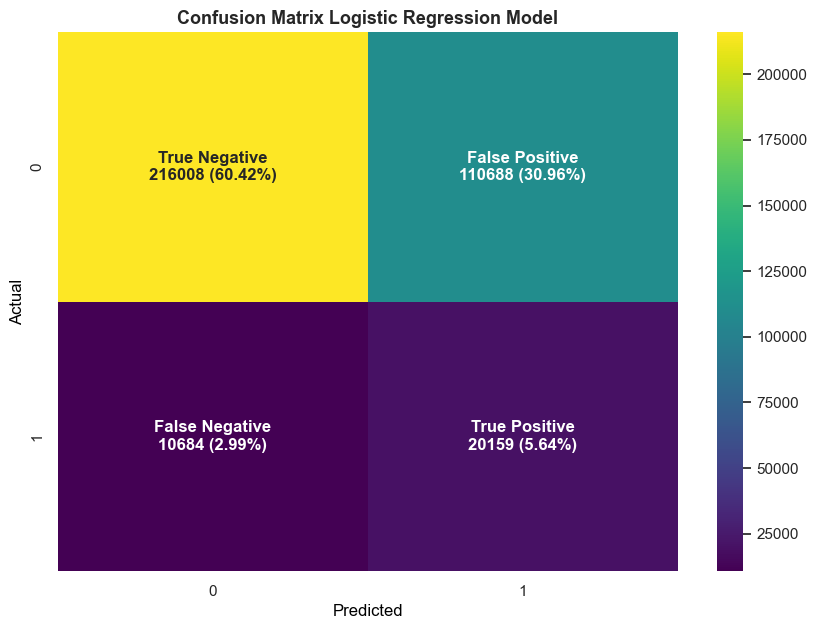

In [35]:
lr = LogisticRegression(solver='newton-cg', penalty='l2', max_iter=100, class_weight='balanced', C=1, random_state=1103)

# Fit the model
lr.fit(Xtrain_selected_woe, y_train)
# Assuming X_test is your test dataset and model is your Gradient Boosting model
y_pred_test = lr.predict(Xtest_selected_woe)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_test)

# Calculate the percentage of each category
percentage_matrix = cnf_matrix / cnf_matrix.sum()

# Define the labels
labels = np.array([['True Negative', 'False Positive'],
                   ['False Negative', 'True Positive']])

# Create labels with both count and percentage
new_labels = (np.asarray(["{0}\n{1} ({2:.2%})".format(label, value, percentage)
                          for label, value, percentage in zip(labels.flatten(), cnf_matrix.flatten(), percentage_matrix.flatten())])
             ).reshape(2,2)

# Plot confusion matrix using a heatmap
fig = plt.figure(figsize=(10,7))
fig.patch.set_facecolor('white')  # Change figure color

sns.heatmap(cnf_matrix, annot=new_labels, fmt='', cmap='viridis', annot_kws={"weight": "bold"})
plt.title('Confusion Matrix Logistic Regression Model', fontsize=13, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Change label colors
plt.gca().xaxis.label.set_color('black')
plt.gca().yaxis.label.set_color('black')

plt.show()

## Scorecard Model

In [36]:
# Create a new model with the best parameters
logreg_new = LogisticRegression(random_state=1103, class_weight='balanced', C= 0.1, solver='liblinear', penalty='l2')

# Fit the new model to the data
logreg_new.fit(Xtrain_selected_woe, y_train)

logreg_new_pred = logreg_new.predict(Xtest_selected_woe)
logreg_new_pred_train = logreg_new.predict(Xtrain_selected_woe)
logreg_new_pred_proba = logreg_new.predict_proba(Xtest_selected_woe)[:,1]
logreg_new_pred_proba_train = logreg_new.predict_proba(Xtrain_selected_woe)[:,1]

# Print the classification report
print(classification_report(y_test, logreg_new_pred))

# Print the confusion matrix
print(confusion_matrix(y_test, logreg_new_pred))

# Print the AUC
print('Train AUC:', roc_auc_score(y_train, logreg_new_pred_proba_train))
print('Test AUC:', roc_auc_score(y_test, logreg_new_pred_proba))

# Print the recall
print('Train Recall:', recall_score(y_train, logreg_new_pred_train))
print('Test Recall:', recall_score(y_test, logreg_new_pred))


              precision    recall  f1-score   support

           0       0.95      0.66      0.78    326696
           1       0.15      0.65      0.25     30843

    accuracy                           0.66    357539
   macro avg       0.55      0.66      0.52    357539
weighted avg       0.88      0.66      0.73    357539

[[216016 110680]
 [ 10680  20163]]
Train AUC: 0.7119746447629978
Test AUC: 0.7145001431920631
Train Recall: 0.6531455074218623
Test Recall: 0.6537301818889213


In [37]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

def plot_roc_pre_recall_curve(y_test, probs):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, probs)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()

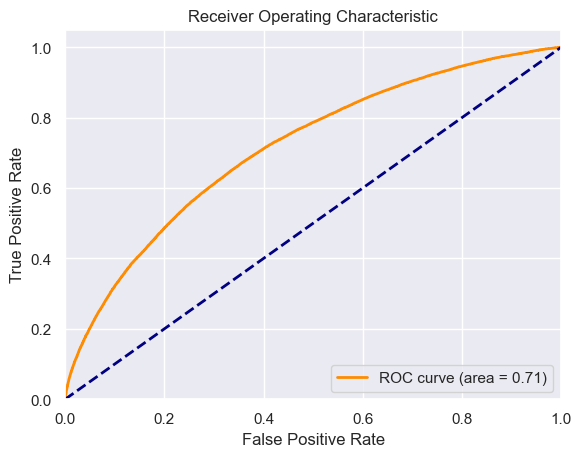

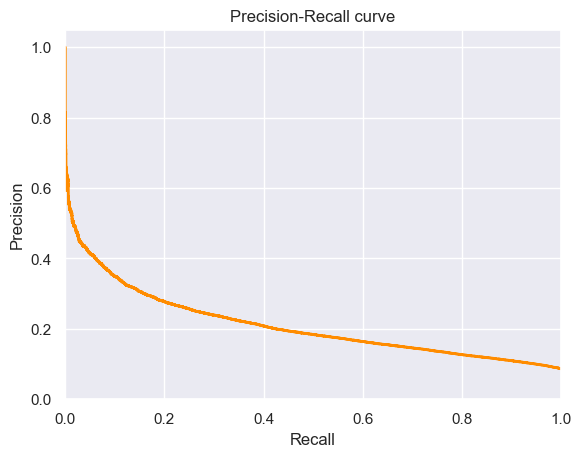

In [38]:
#check AUC
probs = lr.predict_proba(Xtest_selected_woe)[:,1]
sns.set(font_scale = 1)
plot_roc_pre_recall_curve(y_test, probs)

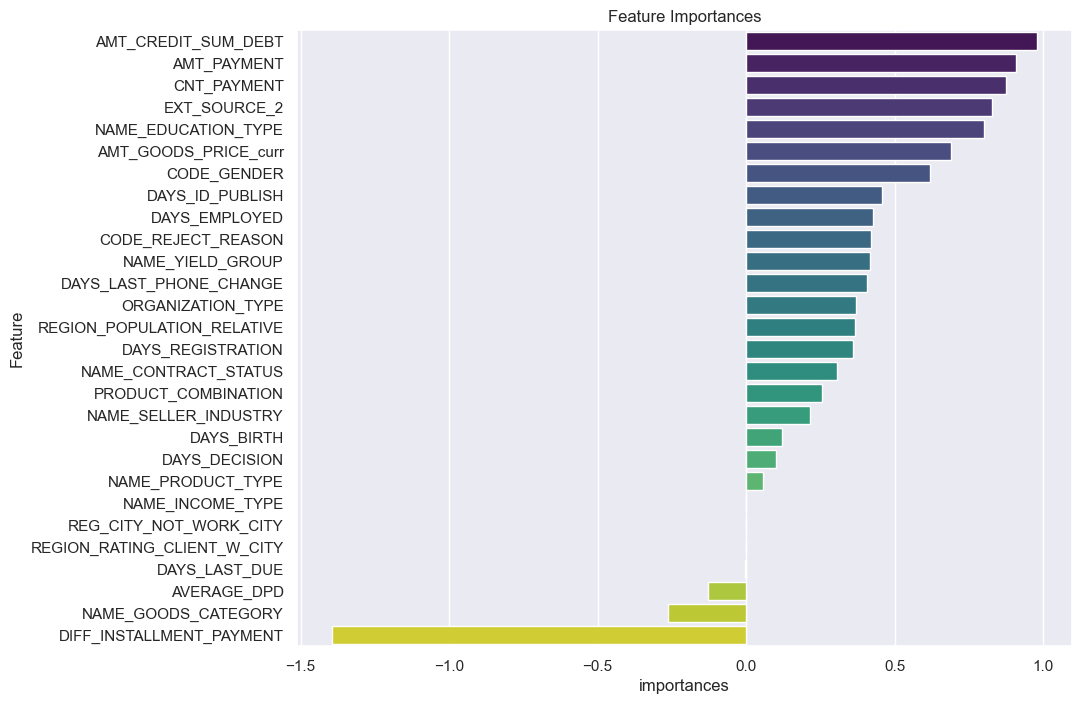

In [39]:
# get the feeature names
features = Xtrain_selected_woe.columns

# get the coefficients from lr model
coefficients = lr.coef_[0]

# create df for feat importancs
feat_importances = pd.DataFrame({'Feature': features,
                                 'importances': coefficients})

# sort df by importances
feat_importances = feat_importances.sort_values(by='importances', ascending=False)

# plot the importances
plt.figure(figsize=(10, 8))
sns.barplot(data=feat_importances, x='importances', y='Feature', palette='viridis')
plt.title('Feature Importances')
plt.show()


In [40]:
# Get the coefficients from the logistic regression model
coefficients = logreg_new.coef_[0]

# Define the scaling factor and offset
factor = 20 / np.log(2)
offset = 600 - factor * np.log(20)

# Scale the coefficients
scaled_coefficients = (coefficients * factor)

# Create a dataframe for the scorecard
scorecard = pd.DataFrame({'Feature': Xtrain_selected_woe.columns, 'Score': scaled_coefficients})

# Calculate the scores for each observation
scores = Xtrain_selected_woe.dot(scaled_coefficients) + offset

In [89]:
fpr, tpr, thresholds = roc_curve(y_train['TARGET'], scores)

# Calculate the Youden's J statistic for each point on the ROC curve
J = tpr - fpr

# Step 4: Find the optimal cutoff point
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx] / 1000

print(f'Optimal cutoff point: {optimal_threshold}')

Optimal cutoff point: 0.5144971490486486


In [91]:
# # Transform test data
# Xtest_transformed = td.transform(c.transform(X_test))

# Use trained model to predict probabilities
test_probabilities = logreg_new.predict_proba(Xtest_selected_woe)[:, 1]

# Apply the optimal threshold to these probabilities to get binary predictions
test_predictions = (test_probabilities > optimal_threshold).astype(int)

# Create score levels based on the range of scores
bins = np.linspace(min(test_probabilities), max(test_probabilities), 6)  # Change the number of bins as needed
labels = range(5, 0, -1)  # Change the labels as needed
score_levels = pd.cut(test_probabilities, bins=bins, labels=labels)

# Create a DataFrame for easier plotting
cs_df = pd.DataFrame({
    'Score': test_probabilities,
    'Label': y_test['TARGET']  
})

In [92]:
# Apply the optimal threshold to the scores to classify clients
cs_df['Client Type'] = cs_df['Score'].apply(lambda x: 'Good' if x >= optimal_threshold else 'Bad')

# Print the DataFrame
cs_df

,Score,Label,Client Type
731711,0.722097,0,Good
480807,0.274755,0,Bad
1240274,0.346467,0,Bad
900521,0.330753,0,Bad
827722,0.260819,0,Bad
...,...,...,...
547023,0.253448,0,Bad
936177,0.178790,0,Bad
890763,0.686998,1,Good
299560,0.470793,0,Bad


In [127]:
# Assuming 'lr' is your trained Logistic Regression model
# 'Xtrain_selected_woe' is your training data transformed with WoE
# 'pdo' is points to double the odds
# 'base_score' is the score corresponding to base odds
# 'base_odds' is the base odds

# Get the coefficients and intercept from the logistic regression model
coefficients = lr.coef_[0]
intercept = lr.intercept_[0]

# Define the scaling factor and offset
pdo = 80
base_odds = 35
base_score = 1000
factor = pdo / np.log(2)
offset = base_score - factor * np.log(base_odds)

# Calculate the score for each feature
scores = pd.DataFrame(index=Xtrain_selected_woe.index)

for i in range(len(Xtrain_selected_woe.columns)):
    feature = Xtrain_selected_woe.columns[i]
    scores[feature] = (coefficients[i] * Xtrain_selected_woe[feature] + intercept / len(Xtrain_selected_woe.columns)) * factor + offset / len(Xtrain_selected_woe.columns)

# Calculate the total score for each row
scores['Total Score'] = scores.sum(axis=1)

In [173]:
# Assuming 'lr' is your trained Logistic Regression model and 'Xtest' is your test data
# Get the predicted probabilities from the model
y_pred_prob = lr.predict_proba(Xtest_selected_woe)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Find the optimal threshold (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx] * 1000

# Classify the clients based on the optimal threshold
# scores['Class'] = [1 if score >= optimal_threshold else 0 for score in scores['Total Score']]

In [174]:
optimal_threshold

507.19004577061

In [153]:
scores['Total Score'].describe()

count    1.072614e+06
mean     5.600545e+02
std      9.242352e+01
min      1.689676e+02
25%      4.965421e+02
50%      5.589161e+02
75%      6.218272e+02
max      1.078614e+03
Name: Total Score, dtype: float64

In [175]:
cutoff_thresholds = 450
# Classify the clients based on the optimal threshold
scores['Classification'] = ['good' if score >= optimal_threshold else 'bad' for score in scores['Total Score']]

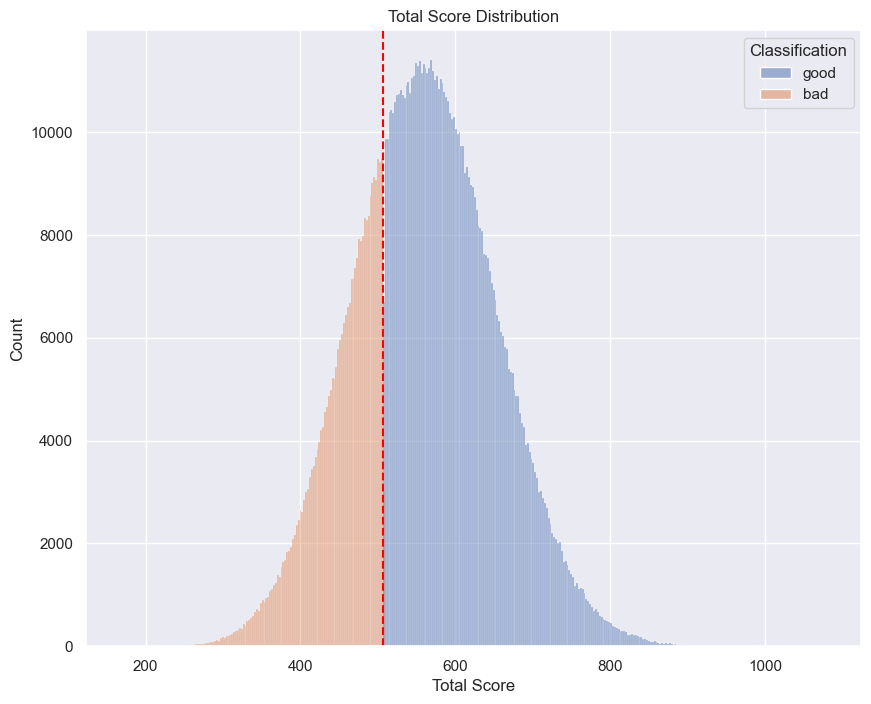

In [177]:
plt.figure(figsize=(10, 8))
sns.histplot(data=scores, x='Total Score', hue='Classification')
plt.axvline(x=optimal_threshold, color='red', linestyle='--')
plt.title('Total Score Distribution')
plt.show()


In [179]:
scores.Classification.value_counts()

Classification
good    763565
bad     309049
Name: count, dtype: int64

In [131]:
scores

,CODE_GENDER,AMT_GOODS_PRICE_curr,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM_DEBT,NAME_CONTRACT_STATUS,DAYS_DECISION,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_LAST_DUE,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AVERAGE_DPD,Total Score,Classification
7003,41.348043,29.071421,24.639037,28.080277,29.067386,29.651256,43.165233,27.139383,51.278419,23.641979,28.729772,31.080502,25.542189,13.737131,19.140582,13.194825,17.163507,8.309996,27.851922,20.908917,42.191788,29.327664,23.999946,22.427621,650.688796,good
792634,41.348043,29.071421,24.527588,33.310728,17.776449,29.651256,35.879366,27.139383,34.985061,5.773643,23.162026,31.080502,-66.874266,36.748831,19.140582,13.194825,29.508791,8.309996,22.261479,20.908917,29.057055,35.127095,34.275283,27.465770,542.829825,good
604873,15.098774,29.071421,24.527588,33.310728,25.027766,27.865257,43.165233,27.139383,10.192975,23.641979,28.729772,33.932960,60.593090,36.748831,38.712260,13.194825,10.531171,8.309996,27.851922,25.632400,51.373323,24.649717,10.283963,22.427621,652.012958,good
360692,41.348043,34.821695,24.527588,-12.527474,22.571849,27.865257,37.266141,23.478782,25.774013,23.641979,23.162026,31.080502,25.542189,13.737131,19.140582,13.194825,17.163507,8.309996,22.261479,20.908917,42.191788,35.127095,34.275283,22.427621,577.290815,good
1389608,15.098774,29.071421,24.639037,33.310728,17.776449,25.991553,37.266141,17.993767,10.192975,23.641979,28.729772,33.932960,127.560003,36.748831,19.140582,30.687375,29.508791,35.882657,28.485459,27.934664,10.304799,15.069097,35.301529,26.335571,720.604919,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11300,15.098774,29.071421,24.527588,28.080277,24.056866,29.651256,43.165233,27.139383,27.956352,23.641979,28.729772,26.464450,25.542189,27.377481,19.140582,13.194825,17.163507,8.309996,27.851922,25.632400,42.191788,24.649717,10.283963,22.427621,591.349344,good
1419949,15.098774,51.550139,24.376963,33.310728,24.056866,18.963497,4.140891,27.139383,16.636053,23.641979,23.162026,6.787385,83.233611,36.748831,-26.191963,13.194825,17.163507,35.882657,28.485459,27.934664,29.057055,35.127095,10.283963,26.335571,586.119962,good
734248,15.098774,-2.158191,24.413303,33.310728,25.027766,25.991553,9.863465,17.993767,10.192975,23.641979,23.162026,21.227119,25.542189,27.377481,19.140582,13.194825,29.508791,35.882657,28.485459,27.934664,25.787184,15.069097,35.301529,26.335571,537.325295,good
509864,15.098774,51.550139,24.527588,33.310728,32.053452,29.651256,43.165233,27.139383,36.919171,38.355596,28.729772,31.080502,60.593090,27.377481,49.314088,30.687375,29.508791,35.882657,28.485459,27.934664,10.304799,15.069097,35.301529,26.335571,768.376199,good


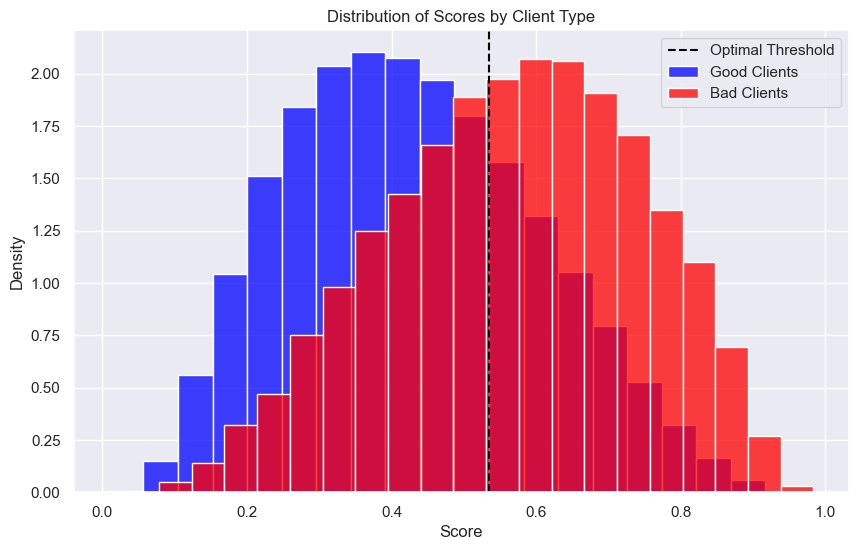

In [117]:
opt_thres = optimal_threshold + 0.02

plt.figure(figsize=(10, 6))
sns.histplot(cs_df[cs_df['Label'] == 0]['Score'], color='blue', label='Good Clients', stat='density', bins=20)
sns.histplot(cs_df[cs_df['Label'] == 1]['Score'], color='red', label='Bad Clients', stat='density', bins=20)
plt.axvline(opt_thres, color='black', linestyle='--', label='Optimal Threshold')
plt.title('Distribution of Scores by Client Type')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()

## Handling Outlier

In [38]:
# def cap_outliers(data, columns):
#     # Create a copy of the data to avoid modifying the original DataFrame
#     result = data.copy()

#     # Loop over each column in the provided list
#     for col in columns:
#         # Calculate the first quartile (Q1) for the current column
#         Q1 = result[col].quantile(0.25)
#         # Calculate the third quartile (Q3) for the current column
#         Q3 = result[col].quantile(0.75)
#         # Calculate the Interquartile Range (IQR) for the current column
#         IQR = Q3 - Q1
#         # Calculate the lower bound for the current column
#         lower_bound = Q1 - (1.5 * IQR)
#         # Calculate the upper bound for the current column
#         upper_bound = Q3 + (1.5 * IQR)
#         # Replace values in the current column that are less than the lower bound with the lower bound
#         result[col] = np.where(result[col] < lower_bound, lower_bound, result[col])
#         # Replace values in the current column that are greater than the upper bound with the upper bound
#         result[col] = np.where(result[col] > upper_bound, upper_bound, result[col])
#     # Return the DataFrame with capped outliers
#     return result

In [39]:
# # Select the names of all numerical columns in the DataFrame X_train_c2
# outliers = X_train_c2.select_dtypes(include='number').columns

# # Call the cap_outliers function on X_train_c2, passing in the names of the numerical columns
# # This will cap the outliers in these columns, and the result is stored in X_train_c3
# X_train_c3 = cap_outliers(X_train_c2, outliers)

## Feature Engineering

In [40]:
# # x train categorical value binning
# X_train_c3['AGE'] = round(abs(X_train_c3['DAYS_BIRTH'] / 365.25)).astype(int)

# X_train_c3 = X_train_c3[X_train_c3.NAME_FAMILY_STATUS != 'Unknown']
# y_train = y_train.drop([194676, 868956])
# X_train_c3 = X_train_c3.drop(columns=['ORGANIZATION_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 
#                                       'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION'], axis=1)

# mapping_dict = {'Family' : 'Companied',
#                 'Spouse, partner': 'Companied',
#                 'Children': 'Companied',
#                 'Other_A': 'Companied',
#                 'Other_B': 'Companied',
#                 'Group of people': 'Companied'}
# X_train_c3 = X_train_c3.replace({'NAME_TYPE_SUITE': mapping_dict})

# map_income_val = {'Unemployed': 'Others', 
#                   'Student': 'Others', 
#                   'Materniity leave': 'Others',
#                   'Businessman': 'Others'}

# X_train_c3 = X_train_c3.replace({'NAME_INCOME_TYPE': map_income_val})


# # x test categorical value binning
# X_test_c3 = X_test_c2.copy()
# X_test_c3['AGE'] = round(abs(X_test_c3['DAYS_BIRTH'] / 365.25)).astype(int)

# X_test_c3 = X_test_c3[X_test_c3.NAME_FAMILY_STATUS != 'Unknown']
# X_test_c3 = X_test_c3.drop(columns=['ORGANIZATION_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 
#                                     'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION'], axis=1)

# X_test_c3 = X_test_c3.replace({'NAME_TYPE_SUITE': mapping_dict})
# X_test_c3 = X_test_c3.replace({'NAME_INCOME_TYPE': map_income_val})

## Feature Encoding

In [17]:
# from sklearn.preprocessing import LabelEncoder

# # Create a LabelEncoder object
# le = LabelEncoder()

# X_train_c4 = X_train_c3.copy()
# # Iterate over all values of each column and extract their dtypes
# for col in X_train_c4.columns:
#     # Compare if the dtype is object
#     if X_train_c4[col].dtype == 'object':
#     # Use LabelEncoder to do the numeric transformation
#         X_train_c4[col] = le.fit_transform(X_train_c4[col])
#         X_test_c3[col] = le.fit_transform(X_test_c3[col])

In [41]:
# # one hot encoding all categorical columns
# X_train_c4 = pd.get_dummies(X_train_c3, drop_first=True).astype(int)
# X_test_c4 = pd.get_dummies(X_test_c3, drop_first=True).astype(int)

## Feature Scaling

In [42]:
# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train_c4)

# X_test_scaled = scaler.transform(X_test_c4)

## Handle Imbalance data

In [27]:
# stomek = SMOTETomek(random_state=1103)
# X_over, y_over = stomek.fit_resample(X_train_scaled, y_train)

In [ ]:
# counts = y_over['TARGET'].value_counts()
# fig, ax = plt.subplots(figsize=(10, 5))
# fig.patch.set_facecolor('#e6ebed')
# gbp = ['#69ba2d', '#d9000c']

# wedges, texts, autotexts = ax.pie(counts,
#                                    labels=['Good Clients', 'Bad Clients'],
#                                    autopct='%1.1f%%',
#                                    colors=gbp,
#                                    startangle=80)

# plt.axis('equal')
# for i, text in enumerate(texts):
#     text.set(text=texts[i].get_text() + f'\n({counts.iloc[i]})')
#     texts[i].set_fontsize(12)
# plt.show()

## Model Building

In [46]:
# def evaluate_model(model, X_train, y_train, X_test, y_test):
#     # Fit the model to the training data
#     model.fit(X_train, y_train)
    
#     # Make predictions on the training data
#     y_train_pred = model.predict(X_train)
    
#     # Make predictions on the testing data
#     y_test_pred = model.predict(X_test)
    
#     # Calculate the accuracy for the training and testing data
#     train_accuracy = accuracy_score(y_train, y_train_pred)
#     test_accuracy = accuracy_score(y_test, y_test_pred)
    
#     # Calculate the precision for the training and testing data
#     train_precision = precision_score(y_train, y_train_pred)
#     test_precision = precision_score(y_test, y_test_pred)
    
#     # Calculate the recall for the training and testing data
#     train_recall = recall_score(y_train, y_train_pred)
#     test_recall = recall_score(y_test, y_test_pred)
    
#     # Calculate the F1 score for the training and testing data
#     train_f1 = f1_score(y_train, y_train_pred)
#     test_f1 = f1_score(y_test, y_test_pred)

#     # Calculate the ROC AUC for the training and testing data
#     train_roc_auc = roc_auc_score(y_train, y_train_pred)
#     test_roc_auc = roc_auc_score(y_test, y_test_pred)
    
#     return {
#         'model': model.__class__.__name__,
#         'train_recall': round(train_recall, 2),
#         'test_recall': round(test_recall, 2),
#         'train_roc_auc': round(train_roc_auc, 2),
#         'test_roc_auc': round(test_roc_auc, 2)
#     }

In [60]:
# # import xgboost model
# from xgboost import XGBClassifier

# # import gradient boosting model
# from sklearn.ensemble import GradientBoostingClassifier

# lr = LogisticRegression(random_state=1103, class_weight='balanced')
# xgb = XGBClassifier(random_state=1103)
# gbc = GradientBoostingClassifier(random_state=1103)

# models = [lr, xgb]

# results = [evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test) for model in models]

# # Convert the results to a DataFrame
# df_model = pd.DataFrame(results)

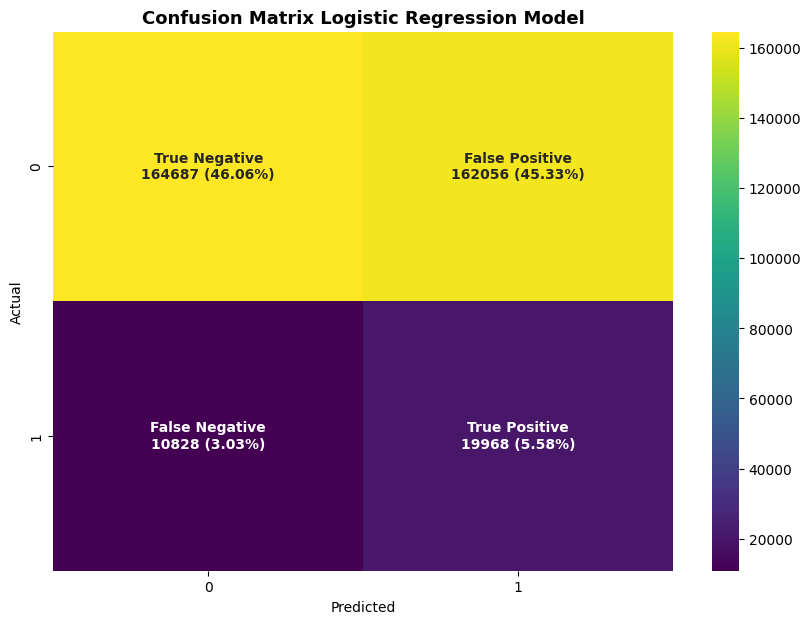

In [53]:
# # Assuming X_test is your test dataset and model is your Gradient Boosting model
# y_pred = lr.predict(X_test_scaled)

# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, y_pred)

# # Calculate the percentage of each category
# percentage_matrix = cnf_matrix / cnf_matrix.sum()

# # Define the labels
# labels = np.array([['True Negative', 'False Positive'],
#                    ['False Negative', 'True Positive']])

# # Create labels with both count and percentage
# new_labels = (np.asarray(["{0}\n{1} ({2:.2%})".format(label, value, percentage)
#                           for label, value, percentage in zip(labels.flatten(), cnf_matrix.flatten(), percentage_matrix.flatten())])
#              ).reshape(2,2)

# # Plot confusion matrix using a heatmap
# fig = plt.figure(figsize=(10,7))
# fig.patch.set_facecolor('white')  # Change figure color

# sns.heatmap(cnf_matrix, annot=new_labels, fmt='', cmap='viridis', annot_kws={"weight": "bold"})
# plt.title('Confusion Matrix Logistic Regression Model', fontsize=13, fontweight='bold')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')

# # Change label colors
# plt.gca().xaxis.label.set_color('black')
# plt.gca().yaxis.label.set_color('black')

# plt.show()